In [2]:
import pandas as pd

base_path = '/content/drive/MyDrive/healthcarefraud_detection/data/processed'

train_inp = pd.read_parquet(f'{base_path}/cleaned_inpatient.parquet')
train_out = pd.read_parquet(f'{base_path}/cleaned_outpatient.parquet')
train_bene = pd.read_parquet(f'{base_path}/cleaned_beneficiary.parquet')
train = pd.read_parquet(f'{base_path}/cleaned_train_labels.parquet')



In [3]:
print(train_inp.shape, train_out.shape, train_bene.shape, train.shape)


(40474, 30) (517737, 27) (138556, 26) (5410, 2)


##Step 2: Create Provider-Claim Aggregations (Step 1A)


In [4]:
import numpy as np

# Add claim type
train_inp['ClaimType'] = 'Inpatient'
train_out['ClaimType'] = 'Outpatient'

claims = pd.concat([train_inp, train_out], axis=0, ignore_index=True)

# Core claim counts per provider
prov_claims = claims.groupby('Provider').agg(
    total_claims=('ClaimID', 'count'),
    inpatient_claims=('ClaimType', lambda x: (x == 'Inpatient').sum()),
    outpatient_claims=('ClaimType', lambda x: (x == 'Outpatient').sum()),
    total_reimb=('InscClaimAmtReimbursed', 'sum'),
    avg_reimb=('InscClaimAmtReimbursed', 'mean'),
    median_reimb=('InscClaimAmtReimbursed', 'median'),
    std_reimb=('InscClaimAmtReimbursed', 'std'),
    max_reimb=('InscClaimAmtReimbursed', 'max'),
    total_deductible=('DeductibleAmtPaid', 'sum'),
    avg_deductible=('DeductibleAmtPaid', 'mean')
).reset_index()

# Inpatient/Outpatient ratio (handle divide by zero)
prov_claims['inpt_outpt_ratio'] = prov_claims['inpatient_claims'] / prov_claims['outpatient_claims'].replace(0, np.nan)

# Claims per month placeholder (will add if date range is sufficient)

prov_claims.head()


,Provider,total_claims,inpatient_claims,outpatient_claims,total_reimb,avg_reimb,median_reimb,std_reimb,max_reimb,total_deductible,avg_deductible,inpt_outpt_ratio
0,PRV51001,25,5,20,104640,4185.600000,400.0,10796.091144,42000,5340.0,213.600000,0.250000
1,PRV51003,132,62,70,605670,4588.409091,1750.0,7309.794729,57000,66286.0,502.166667,0.885714
2,PRV51004,149,0,149,52170,350.134228,70.0,689.963754,3300,310.0,2.080537,0.000000
3,PRV51005,1165,0,1165,280910,241.124464,70.0,491.556392,4080,3700.0,3.175966,0.000000
4,PRV51007,72,3,69,33710,468.194444,80.0,1433.769116,10000,3264.0,45.333333,0.043478


##Step 3: Add Patient Demographic Features per Provider



In [5]:
# Join claims with beneficiary info
claims_bene = claims.merge(train_bene, on='BeneID', how='left')

# Calculate age at claim (if DOB exists, otherwise use fixed ref year for avg)
claims_bene['AgeAtClaim'] = claims_bene['ClaimStartDt'].dt.year - claims_bene['DOB'].dt.year

prov_bene = claims_bene.groupby('Provider').agg(
    unique_beneficiaries=('BeneID', 'nunique'),
    avg_age=('AgeAtClaim', 'mean'),
    pct_deceased=('HasDied', 'mean'),
    pct_male=('Gender', lambda x: (x==1).mean()),
    race_diversity=('Race', pd.Series.nunique),
    alzheimer_rate=('ChronicCond_Alzheimer', lambda x: (x==1).mean()),
    heartfail_rate=('ChronicCond_Heartfailure', lambda x: (x==1).mean()),
    kidney_rate=('ChronicCond_KidneyDisease', lambda x: (x==1).mean()),
    diabetes_rate=('ChronicCond_Diabetes', lambda x: (x==1).mean())
    # Add more chronic conditions as needed
).reset_index()
prov_bene.head()


,Provider,unique_beneficiaries,avg_age,pct_deceased,pct_male,race_diversity,alzheimer_rate,heartfail_rate,kidney_rate,diabetes_rate
0,PRV51001,24,78.280000,0.000000,0.360000,2,0.600000,0.760000,0.680000,0.840000
1,PRV51003,117,69.545455,0.007576,0.409091,3,0.424242,0.606061,0.484848,0.757576
2,PRV51004,138,71.812081,0.006711,0.308725,3,0.429530,0.590604,0.335570,0.704698
3,PRV51005,495,69.999142,0.003433,0.438627,3,0.365665,0.583691,0.435193,0.685837
4,PRV51007,58,68.791667,0.013889,0.472222,2,0.361111,0.555556,0.305556,0.680556


##Step 4: Claim Pattern Features

In [6]:
# Claims per beneficiary
prov_claims['claims_per_bene'] = prov_claims['total_claims'] / prov_bene['unique_beneficiaries']

# % beneficiaries with >1 claim per provider
multi_claims = claims.groupby(['Provider', 'BeneID']).size().reset_index(name='claims_per_beneid')
multi_claims_flag = multi_claims.groupby('Provider')['claims_per_beneid'].apply(lambda x: (x>1).mean()).reset_index(name='pct_bene_multiclaim')

# Diagnosis and procedure code diversity
claims['DiagnosisDiversity'] = claims[[f'ClmDiagnosisCode_{i}' for i in range(1, 11) if f'ClmDiagnosisCode_{i}' in claims.columns]].apply(lambda x: pd.Series(x).nunique(), axis=1)
claims['ProcedureDiversity'] = claims[[f'ClmProcedureCode_{i}' for i in range(1, 7) if f'ClmProcedureCode_{i}' in claims.columns]].apply(lambda x: pd.Series(x).nunique(), axis=1)

prov_diag_proc = claims.groupby('Provider').agg(
    avg_diag_diversity=('DiagnosisDiversity', 'mean'),
    avg_proc_diversity=('ProcedureDiversity', 'mean')
).reset_index()

# Days between claims (mean per provider)
claims = claims.sort_values(['Provider', 'BeneID', 'ClaimStartDt'])
claims['prev_claim_date'] = claims.groupby(['Provider', 'BeneID'])['ClaimStartDt'].shift(1)
claims['days_since_prev'] = (claims['ClaimStartDt'] - claims['prev_claim_date']).dt.days

prov_days = claims.groupby('Provider').agg(
    avg_days_between_claims=('days_since_prev', 'mean')
).reset_index()

# Merge all pattern features
prov_patterns = prov_claims[['Provider']].merge(multi_claims_flag, on='Provider', how='left') \
                                        .merge(prov_diag_proc, on='Provider', how='left') \
                                        .merge(prov_days, on='Provider', how='left')

prov_patterns.head()


,Provider,pct_bene_multiclaim,avg_diag_diversity,avg_proc_diversity,avg_days_between_claims
0,PRV51001,0.041667,3.200000,0.120000,51.000000
1,PRV51003,0.119658,5.250000,0.363636,103.333333
2,PRV51004,0.057971,2.583893,0.000000,99.000000
3,PRV51005,0.450505,2.586266,0.000000,59.658209
4,PRV51007,0.189655,2.986111,0.013889,118.928571


##Step 5: High-Risk Billing Indicators

In [7]:
# High-value claims
claims['high_value_claim'] = claims['InscClaimAmtReimbursed'] > 10000

# Weekend claims
claims['is_weekend'] = claims['ClaimStartDt'].dt.dayofweek.isin([5,6])  # 5=Saturday, 6=Sunday

# All diagnosis slots filled (10 diagnosis codes present)
diag_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11) if f'ClmDiagnosisCode_{i}' in claims.columns]
claims['all_diag_filled'] = claims[diag_cols].notnull().sum(axis=1) == len(diag_cols)

# All procedure slots filled (6 procedure codes present)
proc_cols = [f'ClmProcedureCode_{i}' for i in range(1, 7) if f'ClmProcedureCode_{i}' in claims.columns]
claims['all_proc_filled'] = claims[proc_cols].notnull().sum(axis=1) == len(proc_cols)

prov_highrisk = claims.groupby('Provider').agg(
    pct_high_value=('high_value_claim', 'mean'),
    pct_weekend=('is_weekend', 'mean'),
    pct_all_diag_filled=('all_diag_filled', 'mean'),
    pct_all_proc_filled=('all_proc_filled', 'mean')
).reset_index()

prov_highrisk.head()


,Provider,pct_high_value,pct_weekend,pct_all_diag_filled,pct_all_proc_filled
0,PRV51001,0.120000,0.320000,0.000000,0.0
1,PRV51003,0.151515,0.227273,0.037879,0.0
2,PRV51004,0.000000,0.261745,0.000000,0.0
3,PRV51005,0.000000,0.303004,0.000858,0.0
4,PRV51007,0.000000,0.250000,0.013889,0.0


##Step 6: Combine All Features into Final Provider Table

In [8]:
# Merge all feature sets on Provider
from functools import reduce

dfs_to_merge = [prov_claims, prov_bene, prov_patterns, prov_highrisk]
feature_table = reduce(lambda left, right: pd.merge(left, right, on='Provider', how='left'), dfs_to_merge)

# Join with fraud label
feature_table = feature_table.merge(train, on='Provider', how='left')

# Handle providers with no claims: fill claim-based features with 0, others with appropriate default (as needed)
claim_feature_cols = [
    'total_claims', 'inpatient_claims', 'outpatient_claims', 'total_reimb', 'avg_reimb', 'median_reimb', 'std_reimb', 'max_reimb',
    'total_deductible', 'avg_deductible', 'inpt_outpt_ratio', 'claims_per_bene',
    'pct_high_value', 'pct_weekend', 'pct_all_diag_filled', 'pct_all_proc_filled'
]
feature_table[claim_feature_cols] = feature_table[claim_feature_cols].fillna(0)

# Fill demographic-based features with overall mean or 0
demo_cols = ['unique_beneficiaries', 'avg_age', 'pct_deceased', 'pct_male', 'race_diversity']
feature_table[demo_cols] = feature_table[demo_cols].fillna(0)

# If label is missing (e.g. for test set), leave as is

feature_table.head()


,Provider,total_claims,inpatient_claims,outpatient_claims,total_reimb,avg_reimb,median_reimb,std_reimb,max_reimb,total_deductible,...,diabetes_rate,pct_bene_multiclaim,avg_diag_diversity,avg_proc_diversity,avg_days_between_claims,pct_high_value,pct_weekend,pct_all_diag_filled,pct_all_proc_filled,PotentialFraud
0,PRV51001,25,5,20,104640,4185.600000,400.0,10796.091144,42000,5340.0,...,0.840000,0.041667,3.200000,0.120000,51.000000,0.120000,0.320000,0.000000,0.0,0
1,PRV51003,132,62,70,605670,4588.409091,1750.0,7309.794729,57000,66286.0,...,0.757576,0.119658,5.250000,0.363636,103.333333,0.151515,0.227273,0.037879,0.0,1
2,PRV51004,149,0,149,52170,350.134228,70.0,689.963754,3300,310.0,...,0.704698,0.057971,2.583893,0.000000,99.000000,0.000000,0.261745,0.000000,0.0,0
3,PRV51005,1165,0,1165,280910,241.124464,70.0,491.556392,4080,3700.0,...,0.685837,0.450505,2.586266,0.000000,59.658209,0.000000,0.303004,0.000858,0.0,1
4,PRV51007,72,3,69,33710,468.194444,80.0,1433.769116,10000,3264.0,...,0.680556,0.189655,2.986111,0.013889,118.928571,0.000000,0.250000,0.013889,0.0,0


##Step 7 : Correlation Matrix

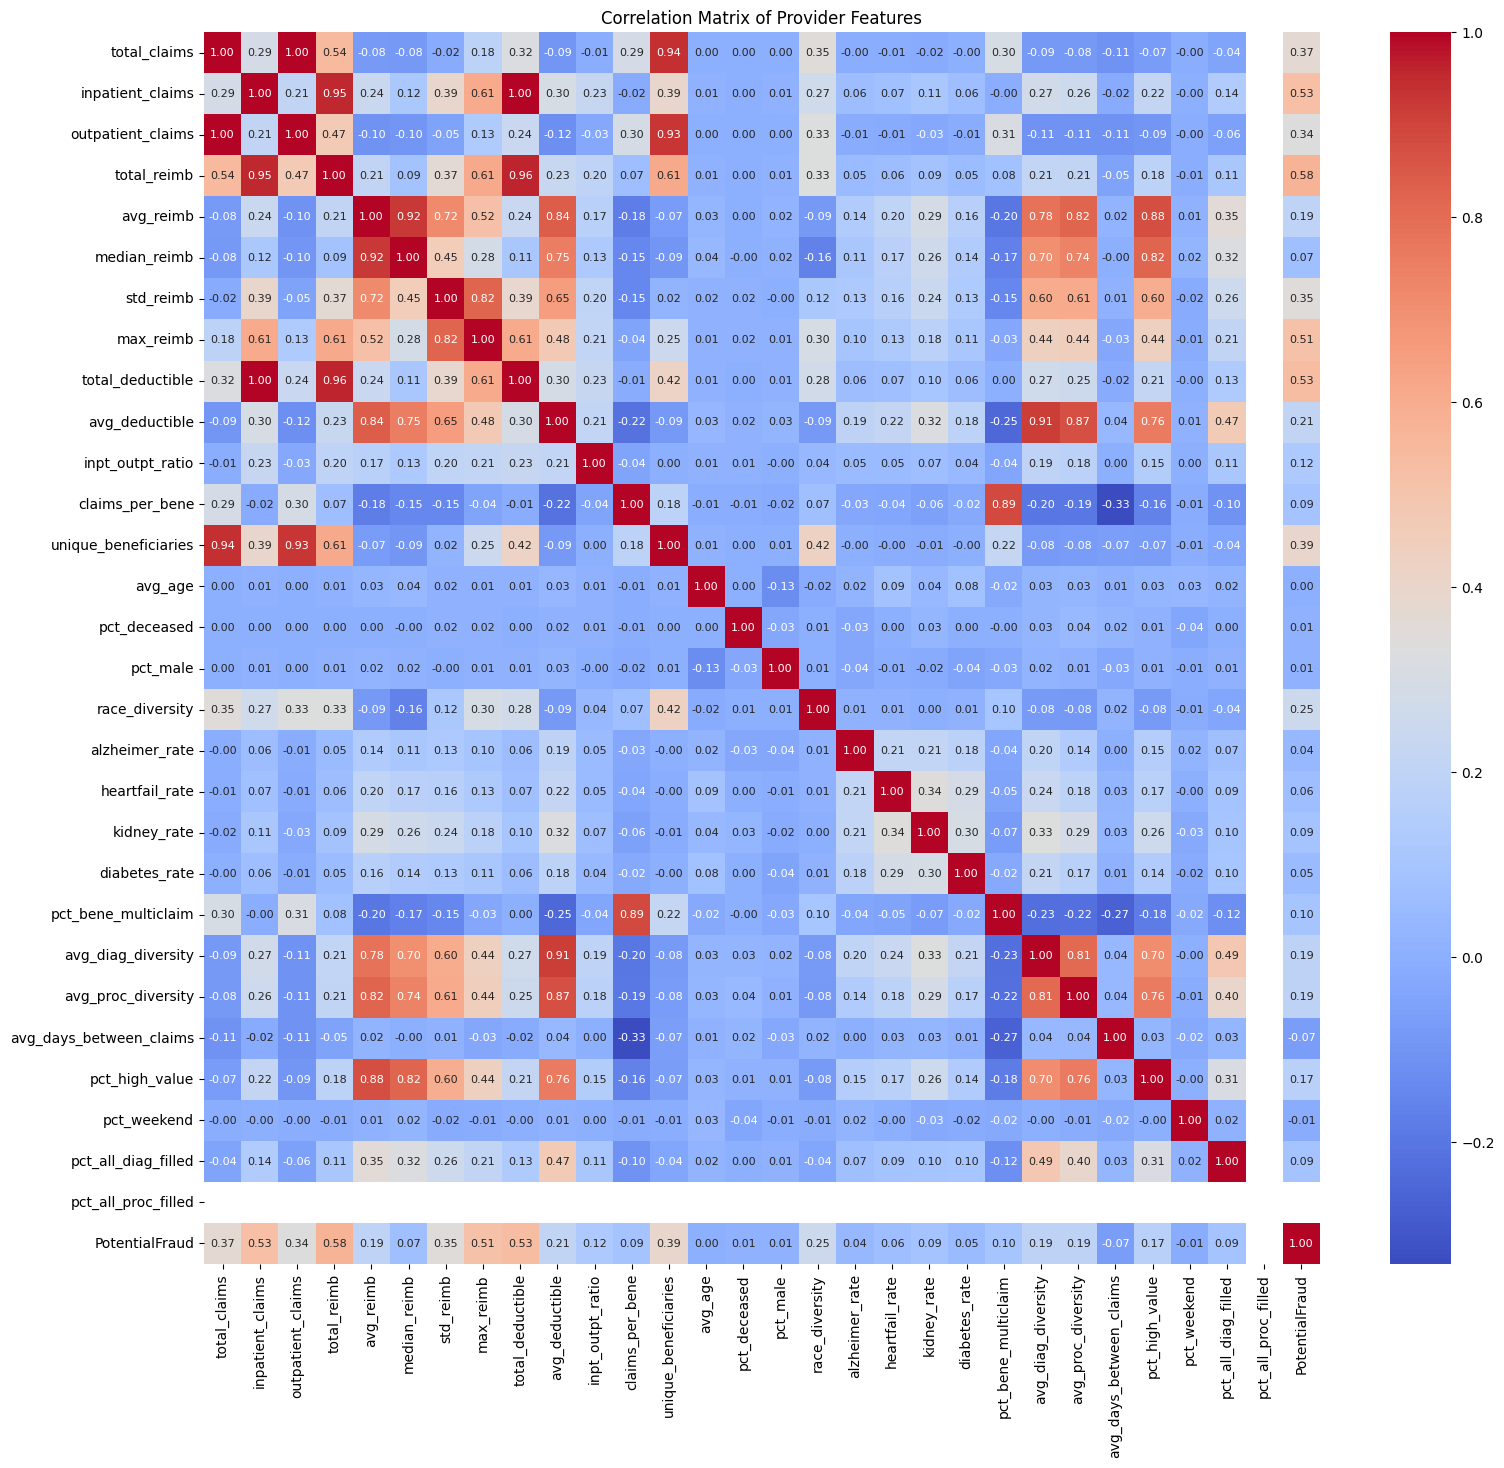

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = feature_table.drop('Provider', axis=1).corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(18, 16)) # Adjust figure size for readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 8}) # Use annot=True to show values
plt.title('Correlation Matrix of Provider Features')
plt.savefig('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/feature_corr_heatmap.png')
plt.show()

##Step 8: Feature Sanity Check & Cleanup

In [10]:
### Step 8A: Remove Provider ID and Useless Columns

# Drop Provider ID from features (keep it for later merging if needed)
feature_table_model = feature_table.drop(['Provider'], axis=1)

# Remove columns with all NaNs or all the same value (constant columns)
na_cols = feature_table_model.columns[feature_table_model.isna().all()].tolist()
const_cols = [col for col in feature_table_model.columns if feature_table_model[col].nunique() <= 1]
print("Columns with all NaN:", na_cols)
print("Constant columns:", const_cols)

# Drop them
feature_table_model = feature_table_model.drop(na_cols + const_cols, axis=1)
print("Feature table shape after cleanup:", feature_table_model.shape)


Columns with all NaN: []
Constant columns: ['pct_all_proc_filled']
Feature table shape after cleanup: (5410, 29)


In [11]:
### Step 8B: Identify Highly Correlated Features

corr_matrix = feature_table_model.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation above threshold
high_corr = [(col, idx) for col in upper.columns for idx in upper.index if upper.loc[idx, col] > 0.95]
print("Highly correlated feature pairs (|corr| > 0.95):")
for pair in high_corr:
    print(pair)


Highly correlated feature pairs (|corr| > 0.95):
('outpatient_claims', 'total_claims')
('total_reimb', 'inpatient_claims')
('total_deductible', 'inpatient_claims')
('total_deductible', 'total_reimb')


In [12]:
### Step 8C: Prepare Feature Sets for Modeling

# 1. Full feature set (for tree models)
X_full = feature_table_model.drop(['PotentialFraud'], axis=1)
y = feature_table_model['PotentialFraud']

# 2. Reduced feature set (for logistic regression/linear models)
# Drop the second in each highly correlated pair (adjust based on domain knowledge if desired)
features_to_drop = [
    'outpatient_claims',    # keep total_claims (captures overall activity)
    'inpatient_claims',     # keep total_reimb (monetary value more informative for LR)
    'total_deductible',     # keep total_reimb (to avoid double removal)
]
X_reduced = X_full.drop(features_to_drop, axis=1)

print("Full feature set shape:", X_full.shape)
print("Reduced feature set shape:", X_reduced.shape)


Full feature set shape: (5410, 28)
Reduced feature set shape: (5410, 25)


##Step 9: Save Feature Table for Modeling

In [13]:
# Save full provider feature table
save_path = '/content/drive/MyDrive/healthcarefraud_detection/data/processed/feature_table.parquet'
feature_table.to_parquet(save_path, index=False)
print(f"Feature table saved: {save_path}")


Feature table saved: /content/drive/MyDrive/healthcarefraud_detection/data/processed/feature_table.parquet


In [14]:
### Step 9: Save Feature Table for Modeling

# Save the main feature table with labels
feature_table.to_parquet('/content/drive/MyDrive/healthcarefraud_detection/data/processed/feature_table_full.parquet', index=False)

# Save the full and reduced feature sets (features only, without labels)
X_full.to_parquet('/content/drive/MyDrive/healthcarefraud_detection/data/processed/X_full.parquet', index=False)
X_reduced.to_parquet('/content/drive/MyDrive/healthcarefraud_detection/data/processed/X_reduced.parquet', index=False)
y.to_frame().to_parquet('/content/drive/MyDrive/healthcarefraud_detection/data/processed/y.parquet', index=False)  # Target as DataFrame

print("Feature datasets saved!")


Feature datasets saved!


### Step 11: Feature Profiling (Summary Stats & Distributions)


,total_claims,inpatient_claims,outpatient_claims,total_reimb,avg_reimb,median_reimb,std_reimb,max_reimb,total_deductible,avg_deductible,...,kidney_rate,diabetes_rate,pct_bene_multiclaim,avg_diag_diversity,avg_proc_diversity,avg_days_between_claims,pct_high_value,pct_weekend,pct_all_diag_filled,PotentialFraud
count,5410.000000,5410.000000,5410.000000,5.410000e+03,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,...,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,3675.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,103.181331,7.481331,95.700000,1.028730e+05,1740.679369,928.602588,2424.047650,13014.913124,8078.560444,153.178678,...,0.420224,0.707307,0.157540,3.404889,0.108011,93.584524,0.045173,0.287415,0.015924,0.093530
std,272.456989,23.704217,266.520526,2.687367e+05,3484.473124,2977.988601,3649.238968,18995.317219,24924.637743,300.941125,...,0.190397,0.168950,0.186006,1.727487,0.246305,45.858857,0.119016,0.156220,0.060472,0.291201
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,7.000000,4.460000e+03,232.394593,70.000000,392.741485,1700.000000,10.000000,0.311286,...,0.333333,0.651475,0.000000,2.500000,0.000000,64.486111,0.000000,0.228070,0.000000,0.000000
50%,31.000000,0.000000,27.000000,1.980500e+04,356.085106,85.000000,674.251609,3300.000000,310.000000,4.285714,...,0.413793,0.714286,0.083333,2.811165,0.000000,85.500000,0.000000,0.284211,0.000000,0.000000
75%,87.000000,5.000000,77.000000,8.556500e+04,1490.154301,100.000000,3400.482846,17000.000000,5340.000000,137.122222,...,0.500000,0.785714,0.250000,3.562260,0.083333,110.387500,0.027508,0.333333,0.006319,0.000000
max,8240.000000,516.000000,8240.000000,5.996050e+06,57000.000000,57000.000000,50204.581464,125000.000000,539426.000000,1068.000000,...,1.000000,1.000000,1.000000,10.000000,3.000000,354.000000,1.000000,1.000000,1.000000,1.000000


Missing values per column:
total_claims                  0
inpatient_claims              0
outpatient_claims             0
total_reimb                   0
avg_reimb                     0
median_reimb                  0
std_reimb                     0
max_reimb                     0
total_deductible              0
avg_deductible                0
inpt_outpt_ratio              0
claims_per_bene               0
unique_beneficiaries          0
avg_age                       0
pct_deceased                  0
pct_male                      0
race_diversity                0
alzheimer_rate                0
heartfail_rate                0
kidney_rate                   0
diabetes_rate                 0
pct_bene_multiclaim           0
avg_diag_diversity            0
avg_proc_diversity            0
avg_days_between_claims    1735
pct_high_value                0
pct_weekend                   0
pct_all_diag_filled           0
PotentialFraud                0
dtype: int64


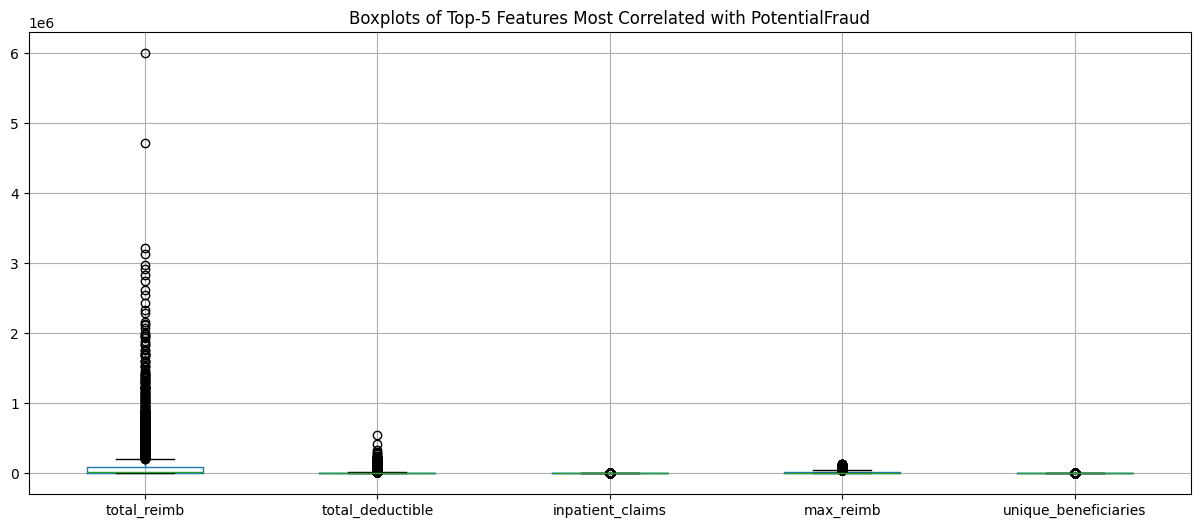

In [26]:
# Numeric summary
display(feature_table_model.describe())

# Quick check for missing data
print("Missing values per column:")
print(feature_table_model.isnull().sum())

# Boxplot for top-5 correlated features with target
import matplotlib.pyplot as plt
# Calculate the top 5 correlated features (excluding the target itself)
top_corr = feature_table_model.corr()['PotentialFraud'].abs().sort_values(ascending=False)[1:6].index

# Convert the pandas Index object to a list of strings
top_corr_list = top_corr.tolist()

# Plot the boxplots using the list of column names
feature_table_model.boxplot(column=top_corr_list, figsize=(15,6))
plt.title("Boxplots of Top-5 Features Most Correlated with PotentialFraud")
plt.savefig('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/most_correlated_feature_with_fraud.png')
plt.show()

# Feature Engineering Notebook Summary

## Overview
This notebook performs comprehensive feature engineering for healthcare fraud detection at the provider level, aggregating claim, beneficiary, and claim-pattern data to produce modeling-ready features.

## Steps Performed

1. **Data Import:** Loaded cleaned inpatient, outpatient, beneficiary, and label data.
2. **Provider-Level Aggregations:** Computed claim counts, reimbursement, and deductible metrics per provider.
3. **Demographic Features:** Added patient age, gender, mortality, and chronic disease prevalence per provider.
4. **Claim Pattern Features:** Engineered features such as unique beneficiaries, claims per beneficiary, multi-claim rates, diagnostic/procedure code diversity, and mean days between claims.
5. **High-Risk Billing Indicators:** Calculated percent of high-value claims, weekend claims, and completeness of diagnosis/procedure code fields.
6. **Feature Merging:** Combined all engineered features into a single provider-level table, linked with the fraud label.
7. **Correlation Analysis:** Visualized feature correlations to check for redundancy, leakage, or multicollinearity.
8. **Feature Cleanup:** Dropped constant or all-NaN columns. Identified highly correlated pairs and created:
    - **Full feature set:** For tree-based models (retains all features).
    - **Reduced feature set:** For linear models (drops highly redundant features).
9. **Dataset Export:** Saved all feature sets for easy reuse in modeling and reproducibility.

## Notes/Findings

- Some claim volume and financial features are highly correlated; handled by feature set bifurcation.
- No severe missing data or constant columns (except `pct_all_proc_filled`).
- Datasets are now ready for robust modeling and further feature selection if needed.

## Output
- `feature_table_full.parquet`: Main engineered table with all features and labels.
- `X_full.parquet`, `X_reduced.parquet`, `y.parquet`: Ready-to-use modeling datasets.

---

**Next step:** Proceed to the Modeling notebook for data splitting, baseline evaluation, and experiment tracking.


In [16]:
feature_table.to_parquet('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/features_full.parquet', index=False)


In [17]:
X_reduced.to_parquet('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/features_reduced.parquet', index=False)


In [18]:
feature_table.describe().T.to_csv('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/features_stats.csv')


In [19]:
feature_table.isnull().sum().to_csv('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/features_missing.csv')
